In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from concurrent.futures import ProcessPoolExecutor

# Specifica i tipi di dati (stringhe) per le colonne 6 e 9
dtype_dict = {'token_id': 'str', 'currency_address': 'str'}

# Carica i dati degli scambi NFT con i tipi di dati specificati
nft_trades_df = pd.read_csv('./database/nfts/nft_trades.csv', dtype=dtype_dict)
merged_twitter_data_df = pd.read_csv('./merged_twitter_data.csv')

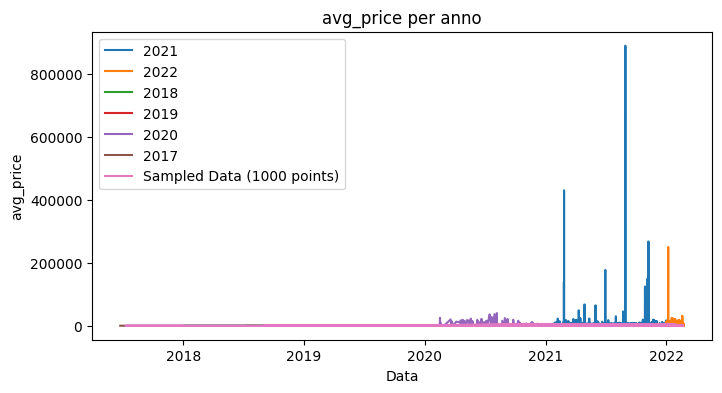

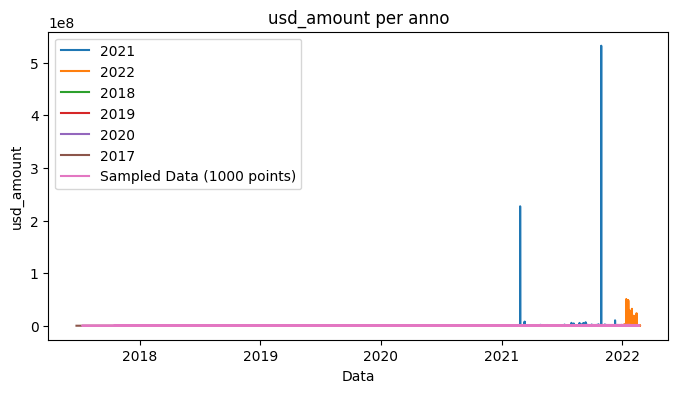

In [4]:
# Estrai l'anno dalla colonna 'date'
nft_trades_df['year'] = pd.to_datetime(nft_trades_df['date']).dt.year

# Scoprire gli anni più importanti dai plot
for feature in ["avg_price", "usd_amount"]:
    plt.figure(figsize=(8, 4))

    for year in nft_trades_df['year'].unique():
        year_data = nft_trades_df[nft_trades_df['year'] == year] # questo me l'ha detto di fare CHAT
        # year_data = nft_trades_df[dataframe['year'] == year] questo è quello che faceva RICHI

        plt.plot(year_data['date'], year_data[feature], label=str(year))

    # Riduci il numero di punti visualizzati campionando casualmente i dati
    sample_size = 1000  # Scegli il numero di punti da visualizzare
    sampled_data = nft_trades_df.sample(n=sample_size, random_state=42)

    # Visualizza il grafico
    plt.plot(sampled_data['date'], sampled_data[feature], label=f"Sampled Data ({sample_size} points)")
    plt.title(f"{feature} per anno")
    plt.xlabel('Data')
    plt.ylabel(feature)
    plt.legend(loc='upper left')
    plt.show()


In [8]:
def find_peaks(data, threshold):
    # Converti la colonna 'date' nel formato datetime
    data['date'] = pd.to_datetime(data['date'])
    # Estrai l'anno dalla colonna 'date'
    data['year'] = data['date'].dt.year
    # Filtra i dati per gli anni 2021 e 2022
    data_2021_2022 = data[data['year'].isin([2021, 2022])]
    # Trova i picchi che superano la soglia
    peaks = data_2021_2022[data_2021_2022['avg_price'] > threshold]
    # Stampa i picchi che superano la soglia, ordinati per data, mostrando solo alcune colonne
    
    print("Picchi che superano la soglia:")
    print(peaks.sort_values(by='date')[
              ['date', 'avg_price', 'contract_address', 'transaction_hash', 'num_items', 'seller', 'buyer', 'token_id',
               'currency', 'currency_address', 'usd_amount', 'platform']])
    # Disegna un grafico per visualizzare i picchi
    plt.figure(figsize=(8, 4))
    plt.plot(data_2021_2022['date'], data_2021_2022['avg_price'], label='avg_price')
    plt.scatter(peaks['date'], peaks['avg_price'], color='red', label='Picchi')
    plt.xlabel('Data')
    plt.ylabel('avg_price')
    plt.title('Individuazione dei picchi di avg_price')
    plt.legend()
    plt.show()
    
    return peaks

Picchi che superano la soglia:
                      date   avg_price  \
147808 2021-02-25 14:28:46  139000.000   
147869 2021-02-26 02:48:36  430000.000   
152427 2021-06-30 23:20:28  177000.000   
230015 2021-08-30 16:33:32  888888.000   
230063 2021-08-30 17:26:04  200000.000   
176892 2021-10-28 23:50:37  124457.068   
59098  2021-11-05 18:42:28  150000.000   
59153  2021-11-08 12:13:12  267500.000   
60806  2022-01-07 07:54:13  250000.000   

                                  contract_address  \
147808  0xc2c747e0f7004f9e8817db2ca4997657a7746928   
147869  0xc2c747e0f7004f9e8817db2ca4997657a7746928   
152427  0xc2c747e0f7004f9e8817db2ca4997657a7746928   
230015  0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7   
230063  0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7   
176892  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   
59098   0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
59153   0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
60806   0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   

       

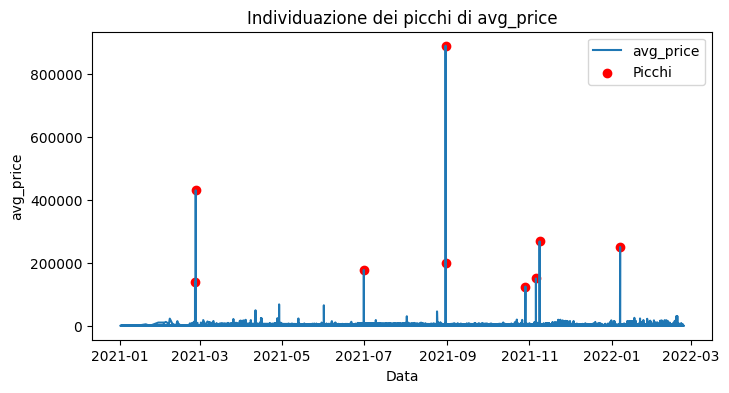

In [9]:

# Chiama la funzione find_peaks con il DataFrame e la soglia desiderata
peaks = find_peaks(nft_trades_df, threshold=80000)
def find_tweets_before_peaks(twitter_data, peaks, days_before):
    # Converti le colonne 'created_at' nel formato datetime
    twitter_data['created_at'] = pd.to_datetime(twitter_data['created_at'])
    peaks['date'] = pd.to_datetime(peaks['date'])
    # Estrai le date dei picchi
    peak_dates = peaks['date']
    tweets_before_peaks_list = []

    # Itera attraverso i picchi
    for i, peak_date in enumerate(peak_dates):
        # Trova tutti i tweet nei giorni precedenti al picco corrente
        tweets_before_peak = twitter_data[
            twitter_data['created_at'].between(peak_date - pd.Timedelta(days=days_before), peak_date)]
        # Rimuovi i duplicati
        tweets_before_peak = tweets_before_peak.drop_duplicates(subset=['created_at', 'user_id', 'tweet_id'])
        # Rimuovi i valori nulli
        tweets_before_peak = tweets_before_peak.dropna()
        # Aggiungi i risultati alla lista
        tweets_before_peaks_list.append(tweets_before_peak)
        # Stampa i risultati
        '''
        print(f"Tweet fatti massimo {days_before} giorni prima del PICCO {i + 1} ({peaks.iloc[i]['date']}):")
        print(tweets_before_peak)
        print("\n" + "-" * 50 + "\n")
        '''
    return tweets_before_peaks_list

In [10]:
# Trova i tweet fatti massimo 2 giorni prima di ciascun picco ottenuto in precedenza
tweets_before_peaks_list = find_tweets_before_peaks(merged_twitter_data_df, peaks, days_before=2)
# questo è il 5% dei tweet più influenti
retweet_percentile = tweets_before_peaks_list[0]['retweet_count'].quantile(0.95)  # Ad esempio, il 95° percentile
like_percentile = tweets_before_peaks_list[0]['like_count'].quantile(0.95)  # Ad esempio, il 95° percentile
'''
print(f"retweet_condition calcolato come {retweet_percentile}")
print(f"like_condition calcolato come {like_percentile}")
'''
def influential_tweets(like, retweet):
    # Filtra i tweet con retweet_count maggiore di 200
    filtered_tweets_list = [tweets[(tweets['retweet_count'] > retweet) & (tweets['like_count'] > like)]
                            for tweets in tweets_before_peaks_list]
    '''
    # Stampa i risultati
    for i, filtered_tweets in enumerate(filtered_tweets_list):
        print(f"Tweet con retweet_count > {retweet} e like_count > {like} --> massimo 2 giorni prima del picco 
        numero {i+1} ({peaks.iloc[i]['date']}):")
        print(filtered_tweets)
        print("\n" + "-"*200 + "\n")
    '''
    return filtered_tweets_list


filtered_tweets_list = influential_tweets(like_percentile, retweet_percentile)

# Crea una lista di set di user_id per ciascun picco
user_id_sets = [set(tweets_before_peak['user_id']) for tweets_before_peak in tweets_before_peaks_list]

# Trova l'intersezione degli insiemi
common_user_ids = set.intersection(*user_id_sets)

# Stampa gli user_id comuni a tutti i 9 picchi
print("Gli user_id comuni a tutti i 9 picchi sono:")
print(common_user_ids)

common_user_tweets = merged_twitter_data_df[merged_twitter_data_df['user_id'].isin(common_user_ids)]
'''
# Stampa il numero di retweet e like per gli user_id comuni
print("Numero di retweet e like per gli user_id comuni:")
print(common_user_tweets.groupby('user_id')[['retweet_count', 'like_count']].sum())
'''
# Calcola la somma di retweet e like per ciascun user_id
user_totals = common_user_tweets.groupby('user_id').agg({'retweet_count': 'sum', 'like_count': 'sum', 'hashtag': 'sum',
                                                         'collection': 'sum'})

# Calcola i percentili basati sulla somma di retweet e like
retweet_percentile_common_user = user_totals['retweet_count'].quantile(0.75)
like_percentile_common_user = user_totals['like_count'].quantile(0.75)
'''
# Stampa i risultati
print(f"retweet comuni a tutti i picchi e più influenti --> {retweet_percentile_common_user}")
print(f"like comuni a tutti i picchi e più influenti --> {like_percentile_common_user}")
'''
# Filtra gli user_id che superano le soglie
influential_users = user_totals[(user_totals['retweet_count'] > retweet_percentile_common_user)
                                & (user_totals['like_count'] > like_percentile_common_user)]

# Stampa gli user_id influenti
print("Gli user_id influenti che superano le soglie del 25%:")
influential_users=influential_users[['retweet_count', 'like_count']]
print(influential_users)

influential_users_data = merged_twitter_data_df[merged_twitter_data_df['user_id'].isin(influential_users.index)]

#da qui non so come andare avanti, bisogna arrivare ad una soluzione insieme

Gli user_id comuni a tutti i 9 picchi sono:
{1357458132608376832, 1364796117851000833, 1171844134530736128}
Gli user_id influenti che superano le soglie del 25%:
Empty DataFrame
Columns: [retweet_count, like_count]
Index: []


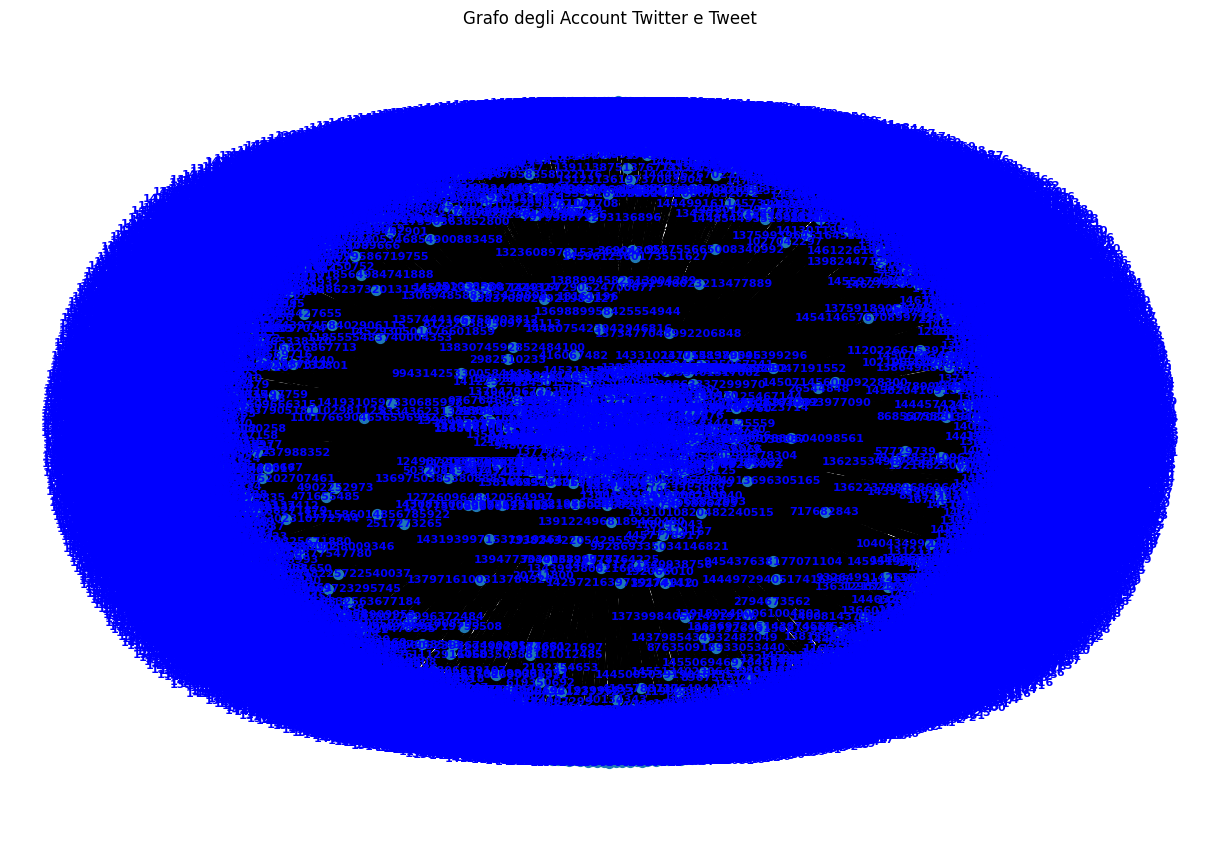

Degree Centrality: {1357458132608376832: 0.3947684505538503, 1437244487424741377: 0.00013345789403443215, 1227725542516023296: 0.0014680368343787536, 1418202136324751363: 0.00013345789403443215, 931940126221131776: 0.005338315761377286, 1461613253482758144: 0.00013345789403443215, 1361594152761360387: 0.00013345789403443215, 1437507951971942406: 0.00013345789403443215, 1361487523210539009: 0.00013345789403443215, 1427247423512997894: 0.011744294675030029, 1435052334703251459: 0.00013345789403443215, 1433538198303555586: 0.05191512077939411, 1445596467960299526: 0.00013345789403443215, 1397301690555146243: 0.00013345789403443215, 1445764165054853125: 0.0017349526224476179, 1453309612824924166: 0.00013345789403443215, 175640387: 0.009742426264513547, 1466415743512178690: 0.00013345789403443215, 1460628765399138305: 0.00013345789403443215, 1477598403420995587: 0.00013345789403443215, 1361564910610767873: 0.00013345789403443215, 109547024: 0.0029360736687575073, 1465641791265206273: 0.0001

In [18]:
# Carica i dati degli scambi NFT
dtype_dict = {'token_id': 'str', 'currency_address': 'str'}
nft_trades_df = pd.read_csv('./database/nfts/nft_trades.csv', dtype=dtype_dict)
merged_twitter_data_df = pd.read_csv('./merged_twitter_data.csv')

# Estrai la sottorete
network_data = merged_twitter_data_df[['user_id', 'tweet_id']].drop_duplicates()

# Rimuovi nodi isolati
network_data_filtered = network_data[network_data['user_id'].isin(network_data['user_id'].value_counts().index)]

# Estrai un campione casuale dei dati
sample_size = 0.2  # Ad esempio, 20% del dataset
sampled_data = network_data_filtered.sample(frac=sample_size, random_state=42)

# Crea il grafo direttamente dal DataFrame campionato
G = nx.from_pandas_edgelist(sampled_data, 'user_id', 'tweet_id', create_using=nx.DiGraph())

# Rimuovi nodi duplicati
G.remove_nodes_from(list(nx.isolates(G)))

# Visualizza il grafo
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, font_size=8, node_size=50, font_color='blue', font_weight='bold')
plt.title('Grafo degli Account Twitter e Tweet')
plt.show()

# Calcola le misure di centralità in parallelo
with ProcessPoolExecutor() as executor:
    degree_centrality = executor.submit(nx.degree_centrality, G)
    closeness_centrality = executor.submit(nx.closeness_centrality, G)
    betweenness_centrality = executor.submit(nx.betweenness_centrality, G)
    eigenvector_centrality = executor.submit(nx.eigenvector_centrality, G)

# Estrai i risultati
degree_centrality = degree_centrality.result()
closeness_centrality = closeness_centrality.result()
betweenness_centrality = betweenness_centrality.result()
eigenvector_centrality = eigenvector_centrality.result()

# Stampa i risultati
print("Degree Centrality:", degree_centrality)
print("Closeness Centrality:", closeness_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Eigenvector Centrality:", eigenvector_centrality)


In [ ]:

# Assumendo che tu abbia una colonna 'hashtags' nel tuo DataFrame dei tweet
hashtags_series = merged_twitter_data_df['hashtags']

# Unisci tutti gli hashtag in un'unica stringa e splitta per il simbolo '#'
all_hashtags = ' '.join(hashtags_series).split('#')

# Conta le occorrenze degli hashtag
hashtag_counts = pd.Series(all_hashtags[1:]).value_counts()

# Visualizza i primi 10 hashtag più frequenti
top_hashtags = hashtag_counts.head(10)
top_hashtags.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 10 degli Hashtag più Frequenti')
plt.xlabel('Hashtag')
plt.ylabel('Frequenza')
plt.show()